The Market
==========

## Orders

We are interested in the modeling of financial markets. In particular the modeling of double auction markets. Unlike in a regular auction, where only buyers compete, in double auctions both buyers and sellers participate. Buyers place bids, sellers place asks and the market finds a way to match them together. A bid consists of a price ùëÉ and a volume ùëâ, such that a bidder guarantees he will buy any number under ùëâ for any price under ùëÉ. An asks consists of a price ùëÉ and a volume ùëâ, such that an asker guarantees he will sell any number under ùëâ for any price over ùëÉ. Bids and asks are called orders and are collected in an order book. This is how most stock exchanges work.  [1]

![orderbook](./assets/orderbook.png)

We can implement this simple behaviour in Python:

In [ ]:
from enum import Enum

class OrderType(Enum):
    BUY = 1
    SELL = 2

class Order:

    def __init__(self, agent_id, type, price, qty):
        self.agent_id = agent_id
        self.type = type
        self.price = price
        self.qty = qty
        
    def __str__(self):
        return "<%s, %d, %d>" % (self.type, self.price, self.qty)
    
    def __repr__(self):
        return str(self)

class Market:
    orders = []
    
    def submit(self, order):
        self.orders.append(order)

## Matching

The Market must find a way to match bidders and askers. There are many ways to do this that suit the needs of different exchanges. We are going to use a simple matching technique called "1/2-Double Auction". It works by calculating a market price based on all bids and all asks and clearing the market with this price. That is to say, all asks bellow this price and all bids above are all cleared with the market price. It works as follow: Sort the bids in ascending order $B_1, \geq B_2 \geq B_3 \dots$ and the asks in descending order $S_1 \leq S_2 \leq S_3 \dots$. Find the maximum trade quantity $l$ such that $B_l > S_l$. Calculate the market price as $(B_l + S_l) / 2$. Clear with this price. [2]

This matching technique does not include volume. However, since our market won't discriminate based on volume or have preferences towards traders, we can easily modify to account for volume as well. We can implement this behaviour in `class Market`.

In [2]:
class Market:
    orders = []
    market_price = 0
    
    def submit(self, order):
        self.orders.append(order)
    
    def clear(self):
        """Calculate a new market_price and clear the market"""
        
        type_is = lambda x: list(filter(lambda y: y.type is x, self.orders))    
        
        asks = type_is(OrderType.SELL)
        bids = type_is(OrderType.BUY)
        
        price = lambda x: x.price
        
        asks.sort(key=price)
        bids.sort(reverse=True, key=price)
        
        market_price = 0;
        
        i, j = 0, 0
        
        while True:
            bid, ask = bids[i], asks[j]          
            
            if bid.price >= ask.price and bid.qty < ask.qty:
                ask.qty -= bid.qty
                i += 1
            elif bid.price >= ask.price and bid.qty > ask.qty:
                bid.qty -= ask.qty
                j += 1
            elif bid.price >= ask.price and bid.qty == ask.qty:
                i += 1
                j += 1

            if bid.price < ask.price or i >= len(bids) or j >= len(asks):
                for x in range(0, i):
                    self.fulfill_order(bids[x])
                
                for y in range(0, j):
                    self.fulfill_order(asks[y])
                    
                break
                
            market_price = (bid.price + ask.price) / 2

        self.market_price = market_price
        
    def fulfill_order(self, order):
        """Fulfill an order. Currently - as we have no actors - we simply remove it from the order book"""
        
        self.orders.remove(order)

# The Actors

Actors interact and learn from the environment. They are described by their policy $\pi$, which dictates which actions they would take in the current state of the environment. Formally, $\pi(a | s)$ is the probability of taking action $a$ in the state $s$. 

The actions $a$ and the states $s$ are members of the action space and the state space. Our action space consists of choosing one of either "BUY", "SELL" or "HOLD" as well as a price and a volume. Here we notice a problem - as we have defined it, our action space is practically infinite, as actors can choose any volume and any price. Because there is no well-established way to deal with such situations, we have to limit our action space to something much smaller.

To begin with, it is not necessary for the actors to be able to choose any price - that is senseless in the real world as well. Orders are placed for prices around the market price. For this reason, we are going to define our price $p$ as one of $\{0, 1, 2, 3, 4, 5\}$ such that if the type of the action is "BUY" we calculate the order price as (102 - p)% of the market price - if it is "SELL" as (98 + p)% of the market price. This corresponds to our intuition that actors want to buy low and sell high. It also provides enough overlap between bids and asks for matching to take place.

In a similar way we define the volume as one of $\{0, 1, 2, 3, 4, 5\}$. Our action space is then the Cartesian product $\{BUY, SELL, HOLD\} \times \{0, 1, 2, 3, 4, 5\} \times \{0, 1, 2, 3, 4, 5\}$. Or in Python:

In [4]:
actions = [(x, y, z) for x in ['BUY', 'SELL', 'HOLD'] for y in range(0, 6) for z in range(0, 6)]

## Zero-Intelligence Actors
The first kind of actor we are going to define is a zero-intelligence actor. It has a random policy.

In [5]:
from bisect import bisect
from random import random
from random import randint

class RandomActor:
    actions = [(x, y, z) \
               for x in ['BUY', 'SELL', 'HOLD'] \
               for y in range(0, 6) \
               for z in range(0, 6)]
    
    def policy(self):
        """Generate a random policy"""
        
        dist = [random() for x in range(len(self.actions))]
        sum_dist = sum(dist)
        return [x / sum_dist for x in dist]
    
    def act(self):
        """Choose an action according to the policy probability distribution"""
        
        policy = self.policy()
        
        cdf = [policy[0]]
        for i in range(1, len(policy)):
            cdf.append(cdf[-1] + policy[i])

        index = bisect(cdf, random())
        
        return self.actions[index]

## Environment
To test our random actors out we would have to create an environment to connect them with the market. At every time steps it asks all the actors for an action, and clears the market.

In [ ]:
class Environment:
    history = []
    
    def __init__(self, num_actors):
        self.market = Market()
        self.actors = [RandomActor() for x in range(num_actors)]
        
        self.market.market_price = randint(200, 500)
    
    def tick(self):
        for actor in self.actors:
            action = actor.act()
            
            if action[0] == "HOLD":
                continue
                
            if action[0] == "SELL":
                order_type = OrderType.SELL
                price = (98 + action[1]) * self.market.market_price / 100
            else:
                order_type = OrderType.BUY
                price = (102 - action[1]) * self.market.market_price / 100
            
            order = Order(id(actor), order_type, price, action[2])
            
            self.market.submit(order)
        
        self.market.clear()
        self.history.append(self.market.market_price)
        
    def advance(self, steps):
        for x in range(steps):
            self.tick()

We can finally test the whole system out and plot the market price after 1000 steps:

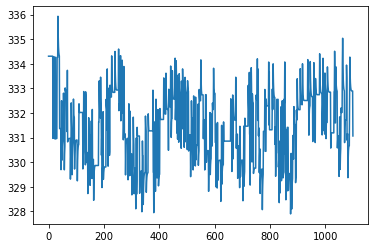

In [11]:
env = Environment(100)
env.advance(1000)

import matplotlib.pyplot as plt
plt.plot(env.history)
plt.show()

Zero-intelligence actors were introduce in an influential paper by Gode and Sunders [1]. They demonstrate zero-intelligence actors model real world markets extremely closes, if they are restrained by budget constraints. We are now in a position to replicate their results. Following their lead, we introduce a budget constraint to the actors; if they request a bid for a price higher than their budget the request is ignored. The exact monetery values of the budget constraints are in actuallity irrelevent - any budget constraint produces almost identical results. We first randomize the budgets for each actor - they each get a budget between 500 and 1500. We add the following to the actor class:

In [ ]:
def __init__(self):
    self.budget = randint(500, 1500)

Following Gode and Saunders, if the actors request a bid higher than their budget, the bid is ignored. We add to the Environment class:

In [ ]:
if action[0] == "BUY" and price > actor.budget:
    continue

We rerun the model with budget constraints. 

In [ ]:
env = Environment(100)
env.advance(1000)
import matplotlib.pyplot as plt
plt.plot(env.history)
plt.show()

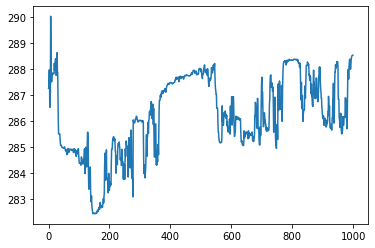

This indeed looks very close to stock price fluctuations. To measure the similarity Gode and Saunders look at equlibrium prices. Instead we are going to measure randomness of the series against real world stock data, using the runs test. The runs test works with two-valued sequences. To produce a two-value sequence from a continuous sequence, we are going to count values above the median as runs up, and values below the median as runs down.

In [8]:
import statistics
import math

def runs_test(seq): 
  
    runs, n1, n2 = 0, 0, 0
    median = statistics.median(seq)
      
    for i in range(len(l)): 
          
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median): 
            runs += 1  
          
        if(l[i]) >= l_median: 
            n1 += 1   
          
        else: 
            n2 += 1   
  
    runs_exp = ((2*n1*n2)/(n1+n2))+1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
  
    z = (runs-runs_exp)/stan_dev 
  
    return z 

Running the runs test on the (normalized) data generated by the model yields:

In [26]:
import numpy as np

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

runs_test(normalize(env.history))

-29.170793929710147


Such a large negative value means our sequence produces results which are much noiser than a completely random distribution would produce. This is however not really important. What is important is how it measures up to real stock data. For this purpose we are going to use Google stock data.

In [12]:
import pandas as pd
goog = pd.read_csv("./assets/GOOG.csv", names=['time', 'open', 'high', 'low', 'close', 'vol'])
goog

time     open     high      low    close  vol
0     2020-01-02 04:00:00  1342.00  1342.20  1342.00  1342.20  424
1     2020-01-02 04:02:00  1344.20  1344.20  1344.20  1344.20  177
2     2020-01-02 08:00:00  1337.02  1337.02  1337.02  1337.02  329
3     2020-01-02 08:09:00  1347.00  1347.00  1347.00  1347.00  155
4     2020-01-02 08:55:00  1348.00  1348.00  1348.00  1348.00  190
...                   ...      ...      ...      ...      ...  ...
3246  2020-01-13 16:40:00  1439.89  1439.89  1439.89  1439.89  999
3247  2020-01-13 16:41:00  1440.00  1440.00  1440.00  1440.00  440
3248  2020-01-13 18:24:00  1439.26  1439.26  1439.26  1439.26  120
3249  2020-01-13 18:34:00  1440.00  1440.00  1440.00  1440.00  479
3250  2020-01-13 18:44:00  1440.00  1440.00  1440.00  1440.00  200

[3251 rows x 6 columns]

Plotting the stock data (we are only interested in 1000 intervals so as to be equivelent to our data):

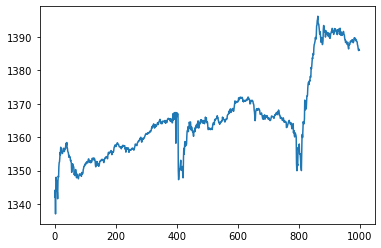

In [15]:
goog.head(1000)['open']

In [25]:
runsTest(normalize(goog['open'].head(1000).tolist()))

-26.892823353002406


This is pretty close to the sequence produced by our zero-intelligence actors. Zero-intelligence actors produce market prices very close to actual markets. This is not a new result. Gode and Saunders reached the same conclusion, and it has been repeated by many others.

## Intelligent Actors

Let's see if "intelligent" actors fare any better. We introduce an RL algorithm. It takes the current state and produces probabilites for the different actions in the action space. We have the same problem with the state space as with the action space - it is too large. The state space is reduced as follows: only the variation in the last 10 steps of the market price are fed to the neural network rounded off to 0.5. The algorithm is implemented in C# (in ./assets/RL).

The results produced by the "intelligent actors" look as follows:

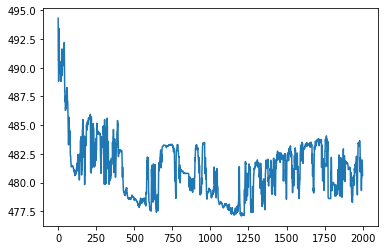

Running it through the runs test we get:

In [35]:
runs_test(normalize(env.history))

-37.441144083351276


A significantly worse result in comparison with the zero-intelligent actors. (Several tests produce significantly noiser results than either real markets or zero-intelligence actors.) Actors in the RL algorithm habitually place bids at the top of their budget and asks significantly lower than zero-intelligence actors. One can never know, of course,
why AI alogrithms behave the way they do; for some reason placing extreme asks and bids seems to result in more profit - and a noisier market. 

There is, however, a serious problem with this market simulation. A fundamental assumption of economic markets is that the actions of an individual can never impact the behaviour of the market. Because the simuation is run with only 100 agents, however, their actions do impact the market; as placing a large bid raises the market price, agents seem to purposefully exploit that. This should never happen in a real-world maket - the price should never be affected by the order of a single agent. I presume if this simulation was run on a much more powerful computer, with more actors, the results would start to approach the real world market. At any rate the zero-intelligent actor results are so close to the real world any improvement in the RL algorithm would be in vain.

## Conclusion

In conclusion the market prices produced by zero-intelligent actors are very close to real markets. Surprisingly, AI algorithms produce much noiser results. As a computer maket simulation could never approach the size of the real-deal, AI algorithms learn to "game" the system and the results they produce are unrealistic. The results suggest zero-intelligence actors simulate the diversity of a real market much better.

This does not mean, however, that traders in the real world act with zero intelligence. It just means that given the enormous size and volatily of real markets, they are much better simulated by randomness than by an AI system. It seems to be the structure of the market that produces rather noisy and random results, rather than any behaviour of the individuals themselves.

## References

[1] Haerigner, G. (2017). Market Design: Auctions and Mathching. MIT Press. 219-223

[2] Babaioff, M., Naom, N. (2004). Concurrent Auctions Across The Supply Chain. Journal of Artificial Intelligence Research, 21, 605.

[3] Gode, D., & Sunder, S. (1993). Allocative Efficiency of Markets with Zero-Intelligence Traders: Market as a Partial Substitute for Individual Rationality. Journal of Political Economy, 101(1), 119-137.